future Story note: not sure *why* this is defunct, honestly, but go to StellarScatteringSesana_wAstropy for the final version, which uses astropy and contains all the figures in the paper and presentation.

# Base Functions

In [3]:
from enterprise import constants as const
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
#from matplotlib import ticker    #comment back in if I want to make x-axis nHz instead of Hz
#from labellines import labelLine, labelLines    #comment back in if you want in-line labels

In [4]:
def getah(totalMass, q, sigma):
    #takes in everything in seconds
    lilM = q * totalMass / (q + 1)
    return lilM / 4 / sigma**2

In [5]:
def getH(separation, Mtot, sigma):
    """ 
    all variables in seconds
    """

    ah = getah(Mtot, 1, sigma)
    a = separation/ah   # define x to be orbital separation in units of ah
    
    A = 14.55
    a0 = 3.48
    gamma = -0.95
    
    return A*(1+a/a0)**gamma

^ as in Sesana (2006), where $H = A\left(1 + \frac{a}{a_0}\right)^{\gamma}$

In [6]:
def ssFrequencyEvolution(M, f, sigma, rho):
    # f is GW frequency in Hz
    # M is total mass in solar masses
    # sigma in km/s
    # rho in solar masses/pc^3 I guess
    
    #set everything to seconds
    M *= const.Tsun # find mass expressed in seconds, rather than solar masses
    sigma = sigma * 1000 / const.c #I THINK. if c=1, that means speeds are generally unitless and expressed as percentage of c?
    rho = rho * const.Msun * const.pc**3 * const.G #I THINK. this gives units of s^-2, not sure if that's right
    
    #find separation (aka a) in terms of current parameters
    a = (M / np.pi**2 / f**2) ** (1/3)
    H = getH(a, M, sigma)
    
    return 3 * (2*np.pi)**(5/6) * rho * H * M**(1/3) * f**(1/3) / 2 / sigma

^ Gives the time derivative of GW frequency due only to stellar scattering, using $\frac{df_{\text{gw}}}{dt} = \frac{3(2\pi)^{5/6}}{2}\frac{\rho H}{\sigma}M_{\text{tot}}^{1/3}f_{\text{gw}}^{1/3}$ (in geometric units)

which is based on $\frac{df_{\text{orb}}}{dt} = \frac{3(2\pi)^{5/6}G^{4/3}}{2}\frac{\rho H}{\sigma}M_{\text{tot}}^{1/3}f_{\text{orb}}^{1/3}$ from Joe Simon's thesis

In [7]:
def gwFrequencyEvolution(mass, gwFreq): #mass in solar masses, freq in s^-1
    orb = np.pi * gwFreq
    M = mass * const.Tsun # find mass expressed in seconds, rather than solar masses
    dOrb = (-96/5) * (M**(5/3)) * (orb**(11/3))
    return dOrb / np.pi

In [8]:
def getHFromFreq(f, M, sigma, rho):
    #set everything to seconds
    M *= const.Tsun # find mass expressed in seconds, rather than solar masses
    sigma = sigma * 1000 / const.c #I THINK. if c=1, that means speeds are generally unitless and expressed as percentage of c?
    rho = rho * const.pc**3 * const.G #I THINK. this gives units of s^-2, not sure if that's right
    
    #find separation (aka a) in terms of current parameters
    a = (M / np.pi**2 / f**2) ** (1/3)
    return getH(a, M, sigma)

# $\Delta H$ Plots

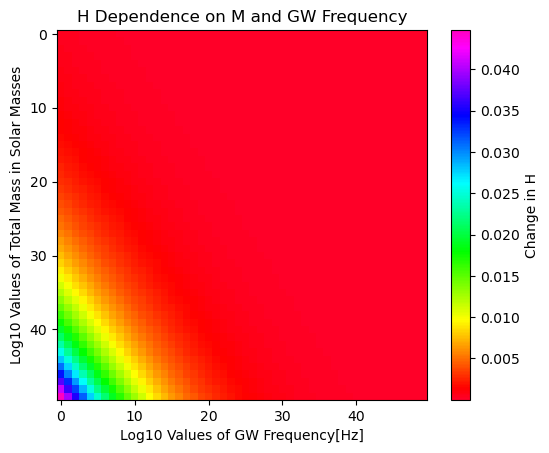

In [8]:
testSigma = 100 #km/s. I think this is a reasonable base value
testDeltaF = 1e-9 #1 nHz, as the difference between the pulsar and Earth term
testRho = 1e9 #milky way density I think

logMSamples = np.linspace(10, 7)
logFSamples = np.linspace(-9, -7)

vals = [0] * len(logMSamples)
for M in range(len(logMSamples)):
    vals[M] = []
    for f in range(len(logFSamples)):
        earthH = getHFromFreq(10 ** logFSamples[f], 10 ** logMSamples[M], testSigma, testRho)
        pulsarH = getHFromFreq(10**logFSamples[f] + testDeltaF, 10 ** logMSamples[M], testSigma, testRho)
        vals[M].append(pulsarH - earthH)
                   
plt.imshow(vals, cmap="gist_rainbow")
plt.colorbar(label=r"Change in H")
plt.xlabel("Log10 Values of GW Frequency[Hz]")
plt.ylabel("Log10 Values of Total Mass in Solar Masses")
plt.title("H Dependence on M and GW Frequency")
plt.show()

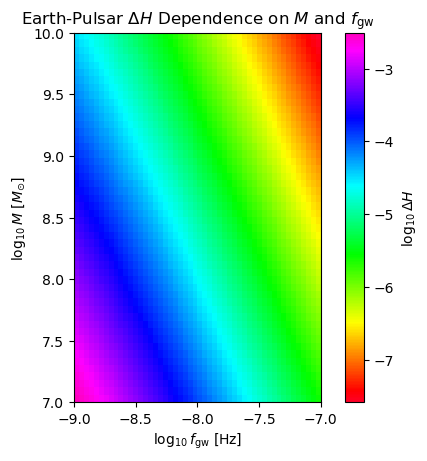

In [9]:
testSigma = 100 #km/s. I think this is a reasonable base value
testDeltaF = 1e-9 #1 nHz, as the difference between the pulsar and Earth term
testRho = 1e9 #seems to be the density of the milky way, as far as I can tell

logMSamples = np.linspace(10, 7)
logFSamples = np.linspace(-9, -7)

logVals = [0] * len(logMSamples)
for M in range(len(logMSamples)):
    logVals[M] = []
    for f in range(len(logFSamples)):
        earthH = getHFromFreq(10 ** logFSamples[f], 10 ** logMSamples[M], testSigma, testRho)
        pulsarH = getHFromFreq(10**logFSamples[f] + testDeltaF, 10 ** logMSamples[M], testSigma, testRho)
        logVals[M].append(np.log10((pulsarH - earthH)/earthH))
                   
plt.imshow(logVals, extent=(-9, -7, 7, 10), cmap="gist_rainbow")
plt.colorbar(label=r"$\log_{10} \Delta H$")
plt.xlabel(r"$\log_{10} f_{\text{gw}}$ [Hz]")
plt.ylabel(r"$\log_{10} M\ [M_{\odot}]$")
plt.title(r"Earth-Pulsar $\Delta H$ Dependence on $M$ and $f_{\text{gw}}$")
plt.show()

In [10]:
testF = 10 ** -9
testM = 10 ** 8

#out of curiosity, using Vc = sqrt(GM/a) and sigma/Vc < sqrt(M2/Mtot)
mSec = testM * const.Tsun
aSec = (mSec / testF**2 / np.pi**2) ** (1/3)
sigmaInC = np.sqrt(mSec / 2 / aSec)
maxSigma = sigmaInC * const.c / 100 #in km/s
print(maxSigma)

#on the order of 10^4

24519.155300779024


Weird. Am I doing something wrong? $\rho$ should have *some* impact.

Those graphs are the ones that seem most important to me, but let's look at the others for completion:

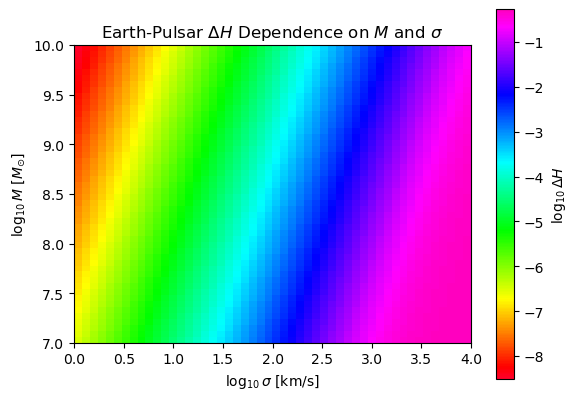

In [11]:
testDeltaF = 1e-9 #1 nHz, as the difference between the pulsar and Earth term
testF = 10 ** -9
testRho = 1e9

logMSamples = np.linspace(10, 7)
logSigmaSamples = np.linspace(0, 4) #milky way seems to have about 10^9 solar masses per kpc so

logVals = [0] * len(logMSamples)
for M in range(len(logMSamples)):
    logVals[M] = []
    for s in range(len(logSigmaSamples)):
        earthH = getHFromFreq(testF, 10 ** logMSamples[M], 10 ** logSigmaSamples[s], testRho)
        pulsarH = getHFromFreq(testF + testDeltaF, 10 ** logMSamples[M], 10 ** logSigmaSamples[s], testRho)
        logVals[M].append(np.log10((pulsarH - earthH)/earthH))
                   
plt.imshow(logVals, extent=(0, 4, 7, 10), cmap="gist_rainbow")
plt.colorbar(label=r"$\log_{10} \Delta H$")
plt.xlabel(r"$\log_{10}\sigma$ [km/s]")
plt.ylabel(r"$\log_{10} M \ [M_{\odot}]$")
plt.title(r"Earth-Pulsar $\Delta H$ Dependence on $M$ and $\sigma$")
plt.show()

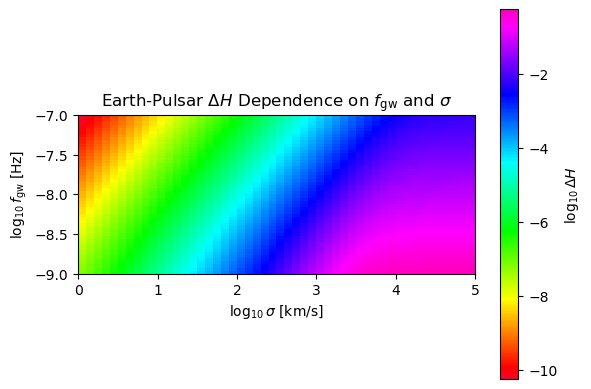

In [12]:
testDeltaF = 1e-9 #1 nHz, as the difference between the pulsar and Earth term
testM = 10 ** 8
testRho = 1e9

logFSamples = np.linspace(-7, -9)
logSigmaSamples = np.linspace(0, 5) #milky way seems to have about 10^9 solar masses per kpc so

logVals = [0] * len(logFSamples)
for f in range(len(logFSamples)):
    logVals[f] = []
    for s in range(len(logSigmaSamples)):
        earthH = getHFromFreq(10 ** logFSamples[f], testM, 10 ** logSigmaSamples[s], testRho)
        pulsarH = getHFromFreq(10**logFSamples[f] + testDeltaF, testM, 10 ** logSigmaSamples[s], testRho)
        logVals[f].append(np.log10((pulsarH - earthH)/earthH))
                   
plt.imshow(logVals, extent=(0, 5, -9, -7), cmap="gist_rainbow")
plt.colorbar(label=r"$\log_{10} \Delta H$")
plt.xlabel(r"$\log_{10} \sigma$ [km/s]")
plt.ylabel(r"$\log_{10} f_{\text{gw}}$ [Hz]")
plt.title(r"Earth-Pulsar $\Delta H$ Dependence on $f_{\text{gw}}$ and $\sigma$")
plt.show()

Ooh! Something that's NOT just a diagonal gradient! So exciting!!

# $H$ Plots

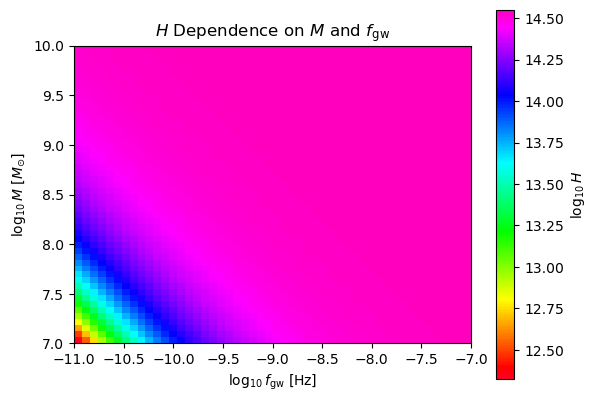

In [13]:
testSigma = 100 #km/s. I think this is a reasonable base value
testDeltaF = 1e-9 #1 nHz, as the difference between the pulsar and Earth term
testRho = 1e9 #seems to be the density of the milky way, as far as I can tell

logMSamples = np.linspace(10, 7)
logFSamples = np.linspace(-11, -7)

logVals = [0] * len(logMSamples)
for M in range(len(logMSamples)):
    logVals[M] = []
    for f in range(len(logFSamples)):
        logVals[M].append(getHFromFreq(10 ** logFSamples[f], 10 ** logMSamples[M], testSigma, testRho))
                   
plt.imshow(logVals, extent=(-11, -7, 7, 10), cmap="gist_rainbow")
plt.colorbar(label=r"$\log_{10} H$")
plt.xlabel(r"$\log_{10} f_{\text{gw}}$ [Hz]")
plt.ylabel(r"$\log_{10} M\ [M_{\odot}]$")
plt.title(r"$H$ Dependence on $M$ and $f_{\text{gw}}$")
plt.show()

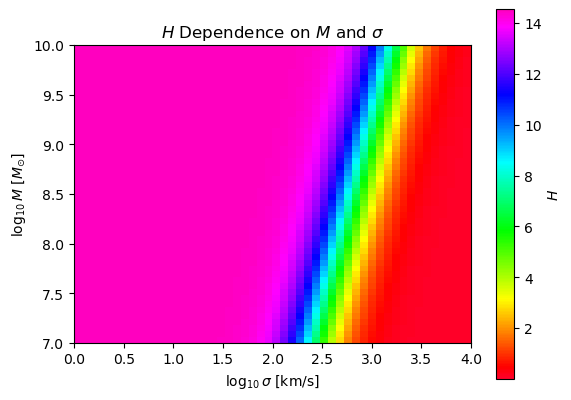

In [23]:
testDeltaF = 1e-9 #1 nHz, as the difference between the pulsar and Earth term
testF = 10 ** -9
testRho = 1e9

logMSamples = np.linspace(10, 7)
logSigmaSamples = np.linspace(0, 5) #milky way seems to have about 10^9 solar masses per kpc so

logVals = [0] * len(logMSamples)
for M in range(len(logMSamples)):
    logVals[M] = []
    for s in range(len(logSigmaSamples)):
        logVals[M].append(getHFromFreq(testF, 10 ** logMSamples[M], 10 ** logSigmaSamples[s], testRho))
                   
plt.imshow(logVals, extent=(0, 4, 7, 10), cmap="gist_rainbow")
plt.colorbar(label=r"$H$")
plt.xlabel(r"$\log_{10}\sigma$ [km/s]")
plt.ylabel(r"$\log_{10} M \ [M_{\odot}]$")
plt.title(r"$H$ Dependence on $M$ and $\sigma$")
plt.show()

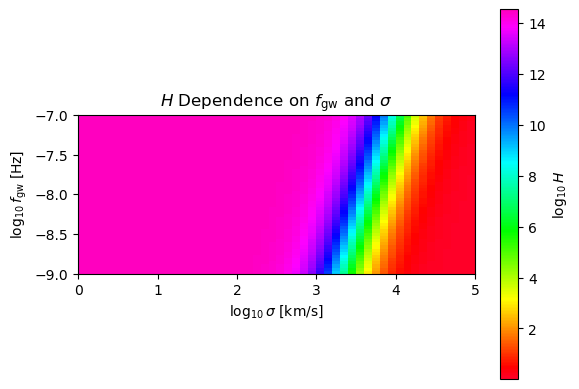

In [15]:
testDeltaF = 1e-9 #1 nHz, as the difference between the pulsar and Earth term
testM = 10 ** 8
testRho = 1e9

logFSamples = np.linspace(-7, -9)
logSigmaSamples = np.linspace(0, 5) #milky way seems to have about 10^9 solar masses per kpc so

logVals = [0] * len(logFSamples)
for f in range(len(logFSamples)):
    logVals[f] = []
    for s in range(len(logSigmaSamples)):
        logVals[f].append(getHFromFreq(10 ** logFSamples[f], testM, 10 ** logSigmaSamples[s], testRho))
                   
plt.imshow(logVals, extent=(0, 5, -9, -7), cmap="gist_rainbow")
plt.colorbar(label=r"$\log_{10} H$")
plt.xlabel(r"$\log_{10} \sigma$ [km/s]")
plt.ylabel(r"$\log_{10} f_{\text{gw}}$ [Hz]")
plt.title(r"$H$ Dependence on $f_{\text{gw}}$ and $\sigma$")
plt.show()

# $\frac{df_{\text{gw}}}{dt}$ Plots

all made assuming that $H$ remains constant

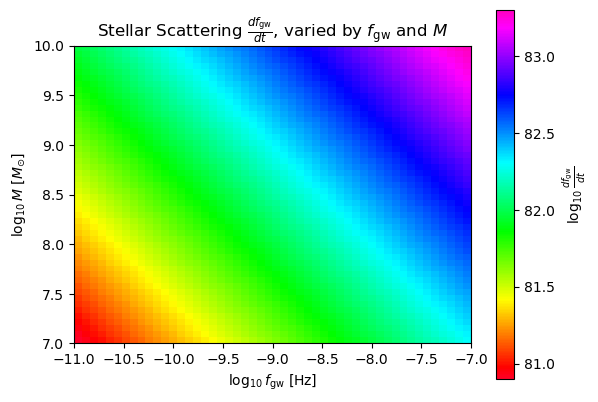

In [16]:
"""
ssFrequencyEvolution(M, f, sigma, rho):
    # f is GW frequency in Hz
    # M is total mass in solar masses
    # sigma in km/s
    # rho in solar masses/pc^3 I guess
    """

testSigma = 100 #km/s. I think this is a reasonable base value
testRho = 1e9 #seems to be the density of the milky way, as far as I can tell

logMSamples = np.linspace(10, 7)
logFSamples = np.linspace(-11, -7)

logVals = [0] * len(logMSamples)
for M in range(len(logMSamples)):
    logVals[M] = []
    for f in range(len(logFSamples)):
        logVals[M].append(np.log10(ssFrequencyEvolution(10 ** logMSamples[M], 10 ** logFSamples[f], testSigma, testRho)))
                   
plt.imshow(logVals, extent=(-11, -7, 7, 10), cmap="gist_rainbow")
plt.colorbar(label=r"$\log_{10} \frac{df_{\text{gw}}}{dt}$")
plt.xlabel(r"$\log_{10} f_{\text{gw}}$ [Hz]")
plt.ylabel(r"$\log_{10} M\ [M_{\odot}]$")
plt.title(r"Stellar Scattering $\frac{df_{\text{gw}}}{dt}$, varied by $f_{\text{gw}}$ and $M$")
plt.show()

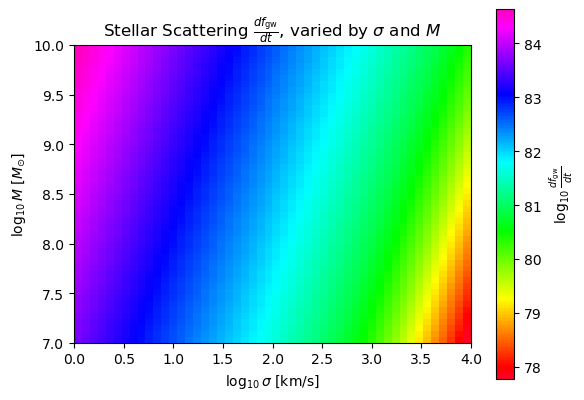

In [17]:
testF = 10 ** -9
testRho = 1e9

logMSamples = np.linspace(10, 7)
logSigmaSamples = np.linspace(0, 4) #milky way seems to have about 10^9 solar masses per kpc so

logVals = [0] * len(logMSamples)
for M in range(len(logMSamples)):
    logVals[M] = []
    for s in range(len(logSigmaSamples)):
        logVals[M].append(np.log10(ssFrequencyEvolution(10 ** logMSamples[M], testF, 10 ** logSigmaSamples[s], testRho)))
                   
plt.imshow(logVals, extent=(0, 4, 7, 10), cmap="gist_rainbow")
plt.colorbar(label=r"$\log_{10} \frac{df_{\text{gw}}}{dt}$")
plt.xlabel(r"$\log_{10} \sigma$ [km/s]")
plt.ylabel(r"$\log_{10} M \ [M_{\odot}]$")
plt.title(r"Stellar Scattering $\frac{df_{\text{gw}}}{dt}$, varied by $\sigma$ and $M$")
plt.show()

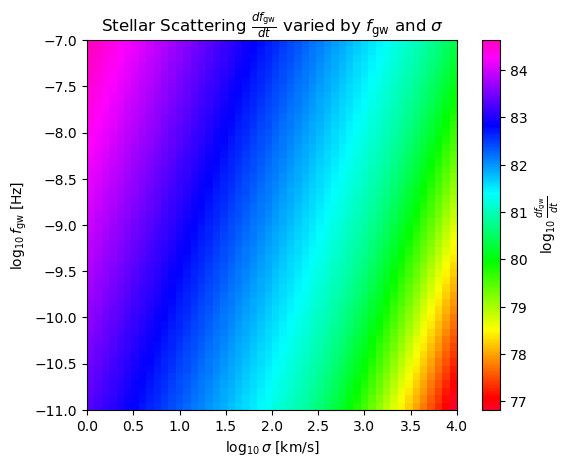

In [18]:
testM = 10 ** 8
testRho = 1e9

logFSamples = np.linspace(-7, -11)
logSigmaSamples = np.linspace(0, 4) #milky way seems to have about 10^9 solar masses per kpc so

logVals = [0] * len(logFSamples)
for f in range(len(logFSamples)):
    logVals[f] = []
    for s in range(len(logSigmaSamples)):
        logVals[f].append(np.log10(ssFrequencyEvolution(testM, 10 ** logFSamples[f], 10 ** logSigmaSamples[s], testRho)))
                   
plt.imshow(logVals, extent=(0, 4, -11, -7), cmap="gist_rainbow")
plt.colorbar(label=r"$\log_{10} \frac{df_{\text{gw}}}{dt}$")
plt.xlabel(r"$\log_{10} \sigma$ [km/s]")
plt.ylabel(r"$\log_{10} f_{\text{gw}}$ [Hz]")
plt.title(r"Stellar Scattering $\frac{df_{\text{gw}}}{dt}$ varied by $f_{\text{gw}}$ and $\sigma$")
plt.show()

interesting!

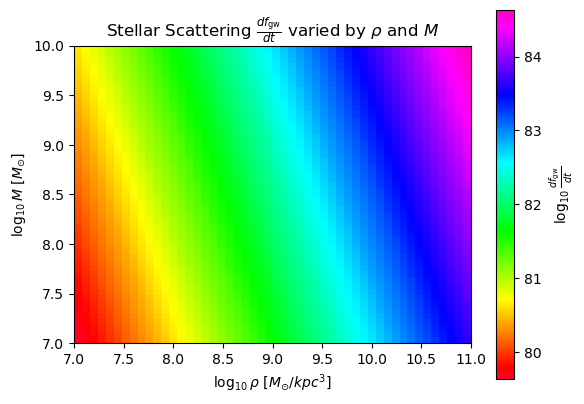

In [19]:
testF = 10 ** -9
testSigma = 100

logMSamples = np.linspace(10, 7)
logRhoSamples = np.linspace(7, 11) #milky way seems to have about 10^9 solar masses per kpc so

logVals = [0] * len(logMSamples)
for M in range(len(logMSamples)):
    logVals[M] = []
    for r in range(len(logRhoSamples)):
        logVals[M].append(np.log10(ssFrequencyEvolution(10 ** logMSamples[M], testF, testSigma, 10 ** logRhoSamples[r])))
                   
plt.imshow(logVals, extent=(7, 11, 7, 10), cmap="gist_rainbow")
plt.colorbar(label=r"$\log_{10} \frac{df_{\text{gw}}}{dt}$")
plt.xlabel(r"$\log_{10} \rho\ [M_{\odot} / kpc^3]$")
plt.ylabel(r"$\log_{10} M \ [M_{\odot}]$")
plt.title(r"Stellar Scattering $\frac{df_{\text{gw}}}{dt}$ varied by $\rho$ and $M$")
plt.show()

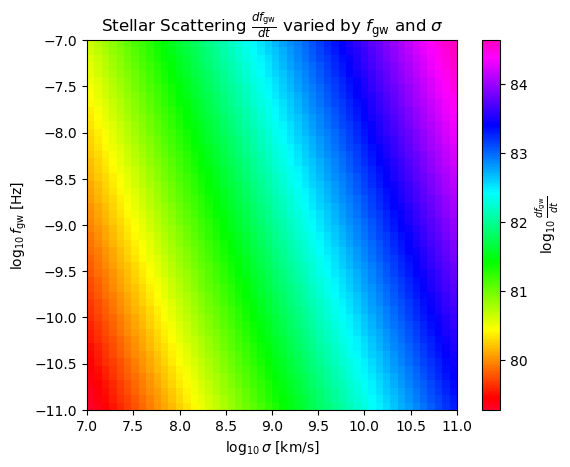

In [20]:
testM = 10 ** 8
testSigma = 100

logFSamples = np.linspace(-7, -11)
logRhoSamples = np.linspace(7, 11) #milky way seems to have about 10^9 solar masses per kpc so

logVals = [0] * len(logFSamples)
for f in range(len(logFSamples)):
    logVals[f] = []
    for r in range(len(logRhoSamples)):
        logVals[f].append(np.log10(ssFrequencyEvolution(testM, 10 ** logFSamples[f], testSigma, 10 ** logRhoSamples[r])))
                   
plt.imshow(logVals, extent=(7, 11, -11, -7), cmap="gist_rainbow")
plt.colorbar(label=r"$\log_{10} \frac{df_{\text{gw}}}{dt}$")
plt.xlabel(r"$\log_{10} \sigma$ [km/s]")
plt.ylabel(r"$\log_{10}f_{\text{gw}}$ [Hz]")
plt.title(r"Stellar Scattering $\frac{df_{\text{gw}}}{dt}$ varied by $f_{\text{gw}}$ and $\sigma$")
plt.show()

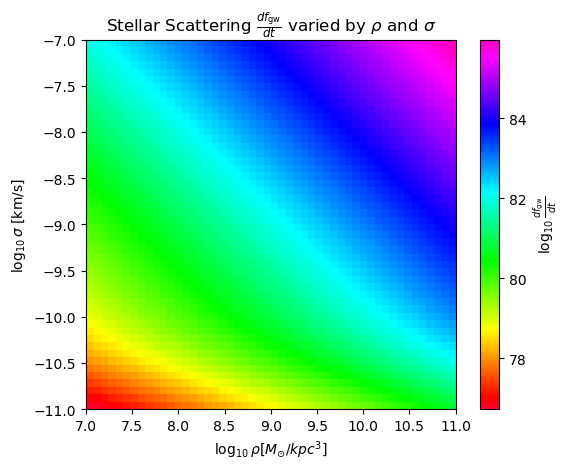

In [21]:
testM = 10 ** 8
testF = 1e-9

logSigmaSamples = np.linspace(0, 4) #milky way seems to have about 10^9 solar masses per kpc so
logRhoSamples = np.linspace(7, 11) #milky way seems to have about 10^9 solar masses per kpc so

logVals = [0] * len(logSigmaSamples)
for s in range(len(logSigmaSamples)):
    logVals[s] = []
    for r in range(len(logRhoSamples)):
        logVals[s].append(np.log10(ssFrequencyEvolution(testM, testF, 10 ** logSigmaSamples[s], 10 ** logRhoSamples[r])))
                   
plt.imshow(logVals, extent=(7, 11, -11, -7), cmap="gist_rainbow")
plt.colorbar(label=r"$\log_{10} \frac{df_{\text{gw}}}{dt}$")
plt.xlabel(r"$\log_{10} \rho [M_{\odot}/kpc^3]$")
plt.ylabel(r"$\log_{10} \sigma$ [km/s]")
plt.title(r"Stellar Scattering $\frac{df_{\text{gw}}}{dt}$ varied by $\rho$ and $\sigma$")
plt.show()

TODO: Sanity check when more awake ^

/tmp/ipykernel_539/1180529973.py:4: RuntimeWarning: invalid value encountered in scalar power
  dOrb = (-96/5) * (M**(5/3)) * (orb**(11/3))


100000000
43527528.16480621


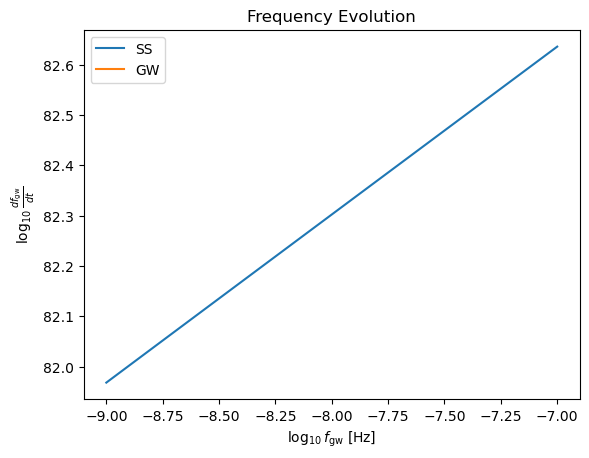

In [24]:
testM = 10 ** 8 #total mass
testq = 1
testSigma = 100
testRho = 1e9
test1 = 1
frequencies = np.linspace(-9, -7)
testChirp = testM * (testq / (1 + testq) ** 2) ** (3/5)

ssVals = []
gwVals = []
for f in range(len(frequencies)):
    ssVals.append(np.log10(ssFrequencyEvolution(testM, 10 ** frequencies[f], testSigma, testRho)))
    gwVals.append(gwFrequencyEvolution(testChirp, frequencies[f]))
    
#plt.plot(frequencies, ssVals, label="SS")
plt.plot(frequencies, gwVals, label="GW")
plt.xlabel(r"$\log_{10} f_{\text{gw}}$ [Hz]")
plt.ylabel(r"$\log_{10} \frac{df_{\text{gw}}}{dt}$")
plt.legend()
plt.title("Frequency Evolution")

print(testM)
print(testChirp)

[-7.040251250696484e+81, -7.265687983475159e+81, -7.498256534191639e+81, -7.7381851240613e+81, -7.98570920228241e+81, -8.241071676770697e+81, -8.50452315224613e+81, -8.776322175902922e+81, -9.056735490901404e+81, -9.346038297928374e+81, -9.644514525080396e+81, -9.952457106333147e+81, -1.0270168268868381e+82, -1.059795982953885e+82, -1.0936153500760871e+82, -1.128508120613321e+82, -1.1645085406091023e+82, -1.2016519433913275e+82, -1.239974784241254e+82, -1.2795146761646343e+82, -1.3203104268000436e+82, -1.3624020765005443e+82, -1.4058309376259878e+82, -1.4506396350844786e+82, -1.4968721481626943e+82, -1.5445738536861033e+82, -1.593791570551361e+82, -1.64457360567458e+82, -1.6969698014005053e+82, -1.751031584419102e+82, -1.8068120162375287e+82, -1.864365845257019e+82, -1.9237495605057267e+82, -1.9850214470802863e+82, -2.04824164335044e+82, -2.1134721999828997e+82, -2.1807771408423136e+82, -2.2502225258291394e+82, -2.3218765157160363e+82, -2.395809439046435e+82, -2.4720938611609238e+82, -

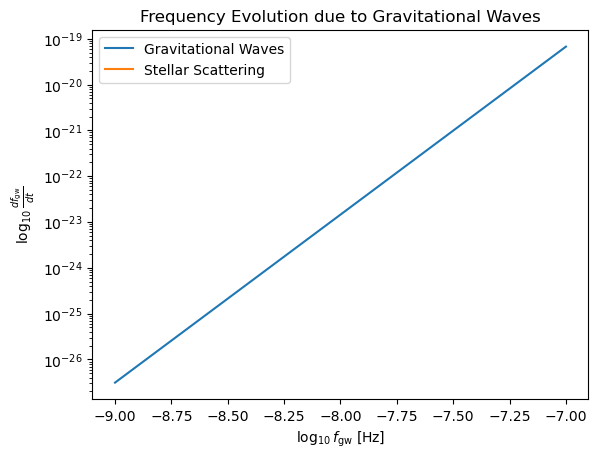

In [25]:
from labellines import labelLine, labelLines

testM = 10 ** 8 #total mass
testq = 1
testSigma = 100
testRho = 1e9
test1 = 1
frequencies = np.linspace(-9, -7)
testChirp = testM * (testq / (1 + testq) ** 2) ** (3/5)

logFrequencySamples = np.linspace(-9, -7)

#works:
gwChangeRates = []
for f in range(len(logFrequencySamples)):
    gwChangeRates.append(-gwFrequencyEvolution(testChirp, 10 ** logFrequencySamples[f]))
    
ssChangeRates = []
for f in range(len(logFrequencySamples)):
    ssChangeRates.append(-ssFrequencyEvolution(43527528.16480621, 10 ** logFrequencySamples[f], testSigma, testRho))
print(ssChangeRates)

#works:
fig, ax = plt.subplots()
ax.plot(logFrequencySamples, gwChangeRates, label="Gravitational Waves")
ax.plot(logFrequencySamples, ssChangeRates, label="Stellar Scattering")
ax.set_yscale('log')
plt.xlabel(r"$\log_{10} f_{\text{gw}}$ [Hz]")
plt.ylabel(r"$\log_{10} \frac{df_{\text{gw}}}{dt}$")
plt.title("Frequency Evolution due to Gravitational Waves")
plt.legend()
plt.show()

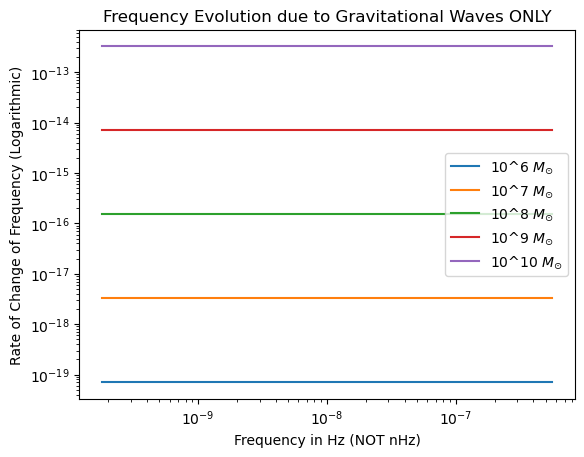

In [10]:
fSamples = []
fInit = (10 ** -0.75) * (10 ** -9) #in hertz
for f in range(8):
    fSamples.append(fInit)
    fInit = fInit * (10 ** 0.5)

masses = [0] * 5
for m in range(11 - 6):
    masses[m] = []
    for w in range(len(fSamples)):
        masses[m].append(-gwFrequencyEvolution(10 ** (m + 6), fSamples[f])) #no, this takes in chirp mass, not total mass

fig, ax = plt.subplots()
for m in range(11 - 6):
    ax.plot(fSamples, masses[m], label='10^' + str(m + 6) + r" $M_{\odot}$")
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel("Frequency in Hz (NOT nHz)")
plt.ylabel("Rate of Change of Frequency (Logarithmic)")
plt.title("Frequency Evolution due to Gravitational Waves ONLY")
plt.legend()
#ax.set_xticks([1, 10, 100])
#ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
plt.show()

**Function graveyard:**

In [72]:
#we're not going to actually use this for anything
#not updated to work properly with newer versions of the functions; basiclaly defunct
def ssSeparationEvolution(totalMass, separation, density, dispersion, q=1):
    """
    Returns the rate of change of the orbital separation of a SMBH binary due to the affects of stellar scattering.
    
    :param totallMass: in solar masses
    :param separation: in parsecs
    :param density: in kg/kpc^3 currently, could change units ranges from 10 to 1000
    :param dispersion: in km/s
    
    :return: da/dt in . . . pc/s, probably?
    """    
    H = getH(q, separationMeters, totalMass, dispersion)
    evolutionSI = (separation ** 2) * const.G * density * H / dispersion #in m/s
    #return in what units?
    return evolutionSI #for now

^ Calculates $\frac{da}{dt}$ using the expression $\frac{a^2G\rho}{\sigma}H$ from Sesana (2013) and Joseph J. Simon's UWM thesis, both of which cite Quinlan (1996), used above.

In [62]:
def defunctGetH(a, totalMass, sigma, q=1):
""" 
    :param totalMass: in solar masses
    :param a: in parsecs
    :param density: in kg/kpc^3 currently, could change units ranges from 10 to 1000
    :param dispersion: in km/s
    """
    qs = np.array([1, 1/3, 1/9, 1/27, 1/81, 1/243])
    As = np.array([14.55, 15.82, 17.17, 18.15, 18.81, 19.16])
    a0s = np.array([3.48, 4.18, 3.59, 3.32, 3.87, 4.16])
    gammas = np.array([-0.95, -0.9, -0.79, -0.77, -0.82, -0.86])
    A = np.interp(q, qs, As)
    
    tempa0 = np.interp(q, qs, a0s) #in units ah
    ah = getah(totalMass, q, sigma)
    a0 = tempa0 * ah #in units meters
    gamma = np.interp(q, qs, gammas)
    

    return A * ( (1 + (a / a0)) ** gamma)